In [ ]:
def bgplvm_simulation(optimize=True, verbose=1,
                      plot=True, plot_sim=False,
                      max_iters=2e4,
                      ):
    from GPy import kern
    from GPy.models import BayesianGPLVM

    D1, D2, D3, N, num_inducing, Q = 13, 5, 8, 45, 3, 9
    _, _, Ylist = _simulate_matern(D1, D2, D3, N, num_inducing, plot_sim)
    Y = Ylist[0]
    k = kern.Linear(Q, ARD=True)  # + kern.white(Q, _np.exp(-2)) # + kern.bias(Q)
    # k = kern.RBF(Q, ARD=True, lengthscale=10.)
    m = BayesianGPLVM(Y, Q, init="PCA", num_inducing=num_inducing, kernel=k)
    m.X.variance[:] = _np.random.uniform(0, .01, m.X.shape)
    m.likelihood.variance = .1

    if optimize:
        print("Optimizing model:")
        m.optimize('bfgs', messages=verbose, max_iters=max_iters,
                   gtol=.05)
    if plot:
        m.X.plot("BGPLVM Latent Space 1D")
        m.kern.plot_ARD()
    return m


In [77]:
from GPy import kern
from GPy.models import BayesianGPLVM
import GPy
import numpy as np

In [78]:
D1, D2, D3, N, num_inducing, Q = 13, 5, 8, 45, 3, 9
plot_sim=1
Q_signal = 4
np.random.seed(3000)

In [79]:
# _, _, Ylist = _simulate_matern(D1, D2, D3, N, num_inducing, plot_sim)
k = GPy.kern.Matern32(Q_signal, 1., lengthscale=(np.random.uniform(1, 6, Q_signal)), ARD=1)
    

In [80]:
for i in range(Q_signal):
    k += GPy.kern.PeriodicExponential(1, variance=1., active_dims=[i], period=3., lower=-2, upper=6)
    t = np.c_[[np.linspace(-1, 5, N) for _ in range(Q_signal)]].T
    K = k.K(t)

In [81]:
s2, s1, s3, sS = np.random.multivariate_normal(np.zeros(K.shape[0]), K, size=(4))[:, :, None]

In [82]:
def generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS):
    S1 = np.hstack([s1, sS])
    S2 = np.hstack([sS])
    S3 = np.hstack([s1, s3, sS])
    Y1 = S1.dot(np.random.randn(S1.shape[1], D1))
    Y2 = S2.dot(np.random.randn(S2.shape[1], D2))
    Y3 = S3.dot(np.random.randn(S3.shape[1], D3))
    Y1 += .3 * np.random.randn(*Y1.shape)
    Y2 += .2 * np.random.randn(*Y2.shape)
    Y3 += .25 * np.random.randn(*Y3.shape)
    Y1 -= Y1.mean(0)
    Y2 -= Y2.mean(0)
    Y3 -= Y3.mean(0)
    Y1 /= Y1.std(0)
    Y2 /= Y2.std(0)
    Y3 /= Y3.std(0)
    return Y1, Y2, Y3, S1, S2, S3

In [83]:
Y1, Y2, Y3, S1, S2, S3 = generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS)
slist = [sS, s1, s2, s3]
slist_names = ["sS", "s1", "s2", "s3"]
Ylist = [Y1, Y2, Y3]

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


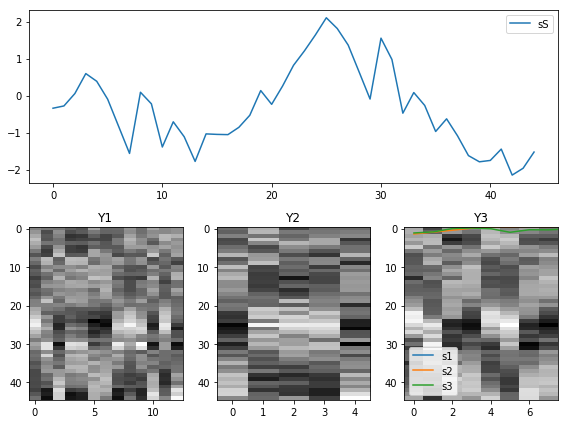

In [34]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import itertools
fig = plt.figure("MRD Simulation Data", figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(2, 1, 1)
labls = slist_names
        
for S, lab in zip(slist, labls):
    ax.plot(S, label=lab)
    ax.legend()
    for i, Y in enumerate(Ylist):
        ax = fig.add_subplot(2, len(Ylist), len(Ylist) + 1 + i)
        ax.imshow(Y, aspect='auto', cmap=cm.gray)  # @UndefinedVariable
        ax.set_title("Y{}".format(i + 1))
    plt.draw()
    plt.tight_layout()

In [92]:
#  return slist, [S1, S2, S3], Ylist
Y = Ylist[0] 
k = kern.Linear(Q, ARD=True)  # + kern.white(Q, _np.exp(-2)) # + kern.bias(Q)

In [114]:
m = BayesianGPLVM(Y, Q, init="PCA", num_inducing=num_inducing, kernel=k)
m.X.variance[:] = np.random.uniform(0, .01, m.X.shape)
m.likelihood.variance = .1

Optimizing model:
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s01  00003   1.832885e+03   1.074064e+05 
    00s06  00013   1.176494e+03   9.555963e+02 
    00s14  00023   1.021967e+03   1.018482e+03 
    00s16  00026   8.229830e+02   3.994454e+03 
    00s19  00032   5.902476e+02   2.868305e+02 
    00s41  00101   4.804808e+02   4.717050e-02 
Runtime:     00s41
Optimization status: Converged



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


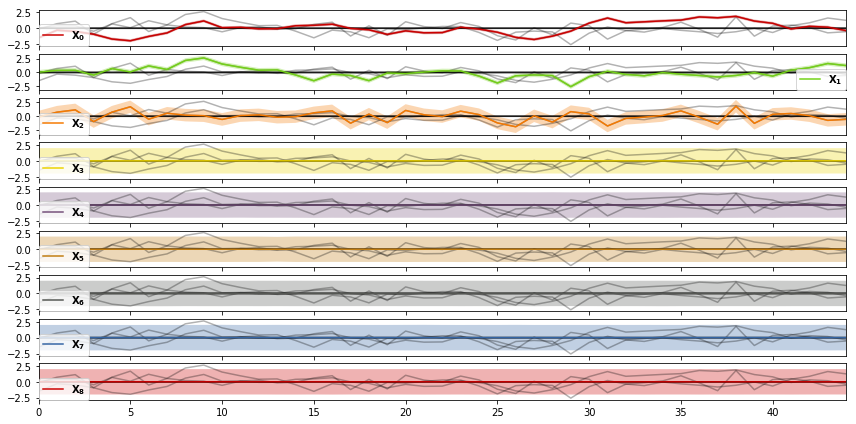

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


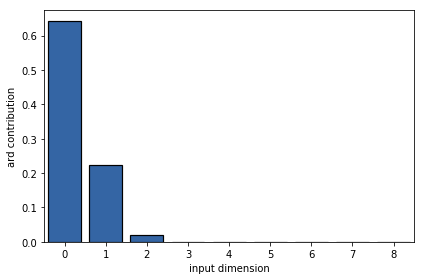

In [115]:
print("Optimizing model:")
max_iters=2e4
m.optimize('bfgs', messages=1, max_iters=max_iters,gtol=.05)
m.X.plot("BGPLVM Latent Space 1D")
m.kern.plot_ARD()

In [118]:
print(m.X.__dict__)

{'_name': 'latent space', '_update_on': True, '_index_operations': OrderedDict([('constraints', <paramz.core.index_operations.ParameterIndexOperationsView object at 0x7f826f18ed68>), ('priors', <paramz.core.index_operations.ParameterIndexOperationsView object at 0x7f826f18ec18>)]), '_default_constraint_': None, '_optimizer_copy_transformed': False, 'parameters': [bayesian_gplvm.latent_space.mean:
Param([[-1.50449620e+00,  3.73590923e-02, -1.43354207e-01,
         2.00424043e-03,  2.42353997e-03, -9.96505386e-05,
         8.02502170e-04, -1.31679853e-04,  1.07238897e-03],
       [-3.06479284e-01,  3.78711345e-01,  7.24135738e-01,
         2.37615770e-03,  3.75913862e-04, -1.62437887e-03,
        -4.69531599e-04, -1.94907455e-03, -9.99980085e-06],
       [-4.91903079e-01,  3.86738968e-01,  1.12959908e+00,
        -2.12720613e-03, -4.02862789e-04, -1.37022876e-03,
         1.15436347e-04, -1.11975913e-03, -6.64208931e-04],
       [-9.35567985e-01, -4.69352709e-01, -9.33839513e-01,
       

In [63]:
m

bayesian_gplvm.,value,constraints,priors
latent space.mean,"(45, 9)",,
latent space.variance,"(45, 9)",+ve,
inducing inputs,"(3, 9)",,
linear.variances,"(9,)",+ve,
Gaussian_noise.variance,0.1,+ve,


# Simulation Through Guassian Processes

In [96]:
verbose=1
max_iters=2e4
from GPy import kern
from GPy.models import GPLVM

k = kern.Linear(Q, ARD=True)  # + kern.white(Q, _np.exp(-2)) # + kern.bias(Q)
m = GPLVM(Y, Q, init="PCA", kernel=k)
m.likelihood.variance = .1
m.optimize('bfgs', messages=verbose, max_iters=max_iters, gtol=.05)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s01  00003   7.777173e+03   7.569448e+07 
    00s03  00011  -1.429890e+02   1.074185e+04 
    00s06  00020  -2.227346e+02   5.974466e+01 
    00s11  00028  -2.236790e+02   2.215612e+00 
    00s16  00039  -2.237435e+02   7.640007e-02 
    00s19  00044  -2.237442e+02   6.754760e-03 
Runtime:     00s19
Optimization status: Converged



In [97]:
m

GPLVM.,value,constraints,priors
latent_mean,"(45, 9)",,
linear.variances,"(9,)",+ve,
Gaussian_noise.variance,0.01062645417486718,+ve,


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


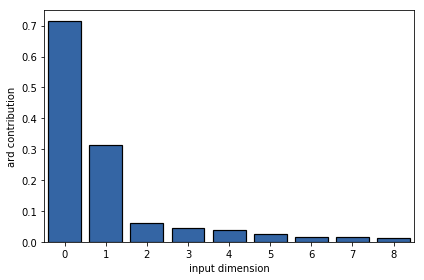

In [99]:
m.kern.plot_ARD()

In [111]:
m.X

{'observers': [(0, <weakref at 0x7f826f5e06d8; to 'Cacher' at 0x7f82740468d0 (_slice_X)>, <bound method Cacher.on_cache_changed of <paramz.caching.Cacher object at 0x7f82740468d0>>), (0, <weakref at 0x7f826f51cb88; to 'Cacher' at 0x7f8274046048 (K)>, <bound method Cacher.on_cache_changed of <paramz.caching.Cacher object at 0x7f8274046048>>), (-inf, <weakref at 0x7f826f792bd8; to 'GPLVM' at 0x7f82751c54e0>, <bound method Parameterizable._pass_through_notify_observers of <GPy.models.gplvm.GPLVM object at 0x7f82751c54e0>>)], '_update_on': True, '_parent_': <GPy.models.gplvm.GPLVM object at 0x7f82751c54e0>, '_parent_index_': 0, '_default_constraint_': None, '_current_slice_': (slice(None, 45, None),), '_realshape_': (45, 9), '_realsize_': 405, '_realndim_': 2, '_original_': GPLVM.latent_mean:
Param([[-1.44737220e+00,  3.17016422e-02, -1.30627700e-01,
         4.96750971e-01,  1.43728663e+00, -5.74378492e-01,
        -2.35081306e-01,  4.82389056e-01,  2.41762937e-01],
       [-2.94862534e-0

In [113]:
print(m.X.__dict__.keys())

dict_keys(['observers', '_update_on', '_parent_', '_parent_index_', '_default_constraint_', '_current_slice_', '_realshape_', '_realsize_', '_realndim_', '_original_', '_name', '_gradient_array_', '_in_init_', '_index_operations', '_optimizer_copy_', '_optimizer_copy_transformed', 'parameters', '_param_array_', '_added_names_', 'logger', '_Parameterizable__visited', 'cache', '_default_prior_', '_fixes_', '_model_initialized_'])
